### Demonstration of Bayesian Perception Concepts

# Case 4: Probabilistic classification with priors

## Example 1: Multi-hypothesis object with neutral prior resolved after several observations

Assumptions:
- Object observed in the middle of road.
- Contextual classification prior defined as class-based probabilities ( p(obj) = 'car', p(obj) = 'bicycle', p(obj) = 'person')
- Contextual classification prior for road p(obj | road) = (0.8, 0.15, 0.05)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from plot_dirichlet import Dirichlet, PlotDirichlet

np.random.seed(seed=0)

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
plot_dirichlet = PlotDirichlet(corners)

### Prior

The prior is context-dependent, meaning the classification prior is set according to the **statistical average of the road type** given the detected low-level features (i.e. some statistics of the pixel and point cloud?)

In this example, the detected object is situated in the middle of the road. Statistically we have observed that the particular low-level features likely correspond to 'car' (p = 0.8), less likely to 'bicycle' (p = 0.15), as well as a low likelihood of 'pedestrian' (p = 0.05).

Prior class distribution | mode(car, bicycle, person) = (0.80, 0.15, 0.05)


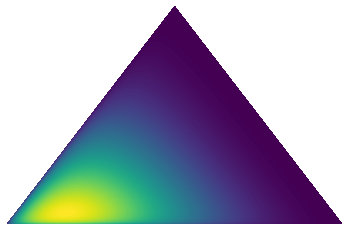

In [2]:
# Prior class distribution and precision for 'road' for the observed low-level features.
prior_prob = [0.8, 0.15, 0.05]  # [p(car), p(bicycle), p(person)]
prior_c = 3.0

prior_alpha = [1.0 + prior_c*prior_prob[0], 1.0 + prior_c*prior_prob[1], 1.0 + prior_c*prior_prob[2]]

prior_alpha_0 = prior_alpha[0] + prior_alpha[1] + prior_alpha[2]

# Mode of prior distribution
prior_mode_1 = (prior_alpha[0] - 1.0) / (prior_alpha_0 - 3.0)
prior_mode_2 = (prior_alpha[1] - 1.0) / (prior_alpha_0 - 3.0)
prior_mode_3 = (prior_alpha[2] - 1.0) / (prior_alpha_0 - 3.0)

print(f"Prior class distribution | mode(car, bicycle, person) = ({prior_mode_1:.2f}, {prior_mode_2:.2f}, {prior_mode_3:.2f})")
f, axes = plt.subplots(figsize=(6,4))
ax = axes#[0, 0]
dist = Dirichlet(prior_alpha)
ax = plot_dirichlet.draw_pdf_contours(ax, dist, prior_alpha)
plt.show()

### Measurements

The true type of the observed object is a hidden parameter we cannot observe directly.

The deep model relying on high-level features initially outputs equal likelihood of 'bicycle' and 'motorcycle', but very likely not 'car', as the object is far-away and thus of low observability.

As the ego-vehicle gets closer to the object, the deep model is able to resolve the ambiguity and confidently classify the object as 'person' with high likelihood.

We assume the measurement device outputs an approximate estimates of distributions, explicitly taking into account enironmental paramters:
- Approximate distance rage (i.e. order of 10 or 100 meters?)
- Illumination (i.e. daylight or dusk)
- Approximate size of object (i.e. large truck or pedestrian?)
- etc.

In [3]:
# Sequence of self-estimated precision of model based on environmental parameters
model_cs = [20, 24, 20, 30, 50, 55, 54]

# Sequence of predicted class probabilities of a model
model_probs = []
model_probs.append([0.02, 0.55, 0.43])  # [p(car), p(bicycle), p(person)]
model_probs.append([0.01 ,0.45, 0.53])
model_probs.append([0.01 ,0.54, 0.55])
model_probs.append([0.01 ,0.06 ,0.93])
model_probs.append([0.01 ,0.04 ,0.95])
model_probs.append([0.01 ,0.03 ,0.96])

### Bayesian inference

The true class distribution is estimated by integrating the prior and noisy measurements using Baye's theorem. This operation leverages the estimated uncertainty to integrate information from both the senses and prior knowledge in a principled manner using the laws of probability.

Biological minds are theorized to do approximate Bayesian inference as well.

In [4]:
# Auxhilary function
def sum_alpha(alpha_buf):
    '''Computes the alpha representing the Dirichlet distr. of the 'N' most recent model measurements.
    Args:
        alpha_buf: List of alpha values [alpha_1, alpha_2, ..., alpha_N]
    Returns:
        Single array of alpha values [val_1, val_2, ... , val_M].
    '''
    alpha_sum = np.zeros(len(alpha_buf[0]))
    for alpha in alpha_buf:
        alpha_sum += alpha
    return alpha_sum

Prior (0.80, 0.15, 0.05), Model [N = 1] (0.02, 0.55, 0.43), Posterior (0.15, 0.48, 0.38)


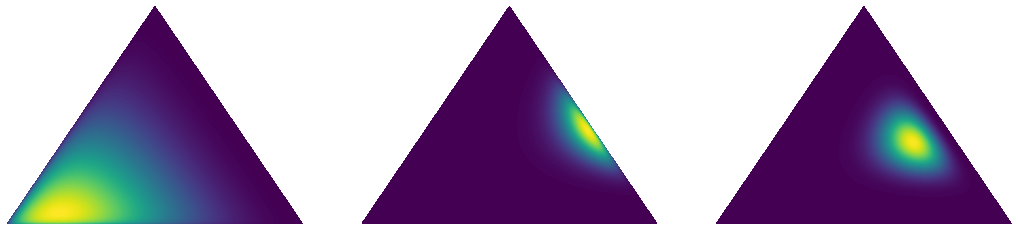

Prior (0.80, 0.15, 0.05), Model [N = 2] (0.07, 0.96, 0.94), Posterior (0.10, 0.46, 0.44)


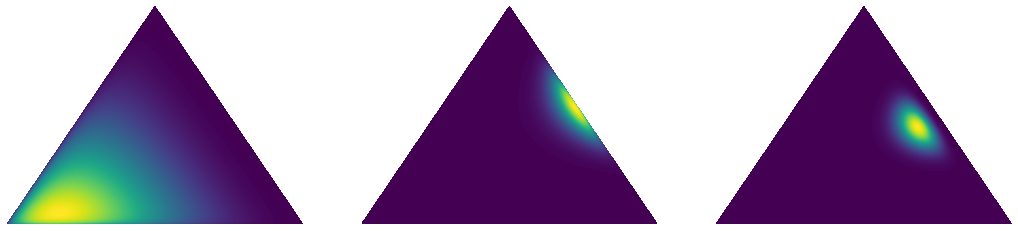

Prior (0.80, 0.15, 0.05), Model [N = 3] (0.13, 1.57, 1.56), Posterior (0.08, 0.46, 0.46)


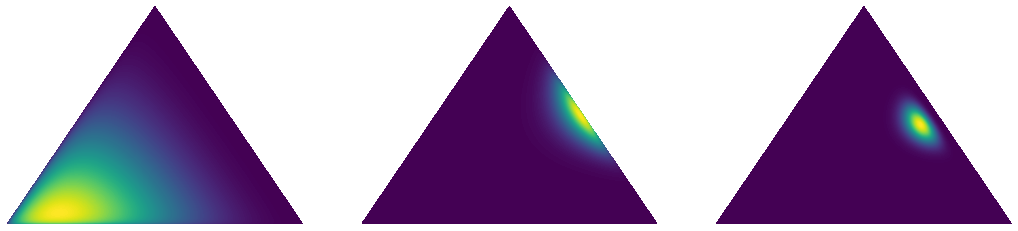

Prior (0.80, 0.15, 0.05), Model [N = 3] (0.09, 0.85, 1.79), Posterior (0.07, 0.31, 0.62)


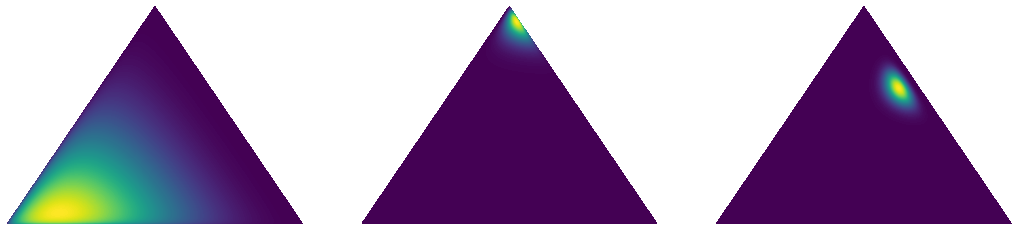

Prior (0.80, 0.15, 0.05), Model [N = 3] (0.06, 0.33, 1.77), Posterior (0.06, 0.16, 0.79)


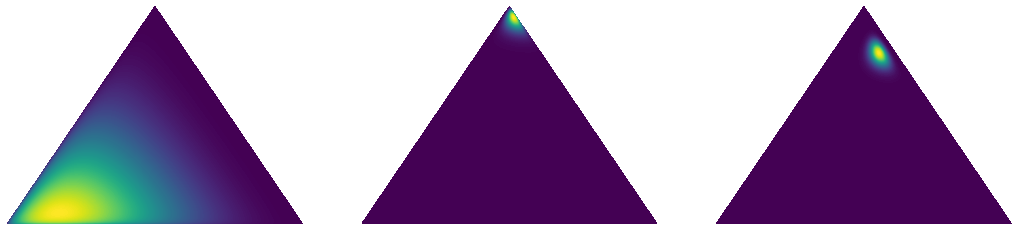

Prior (0.80, 0.15, 0.05), Model [N = 3] (0.06, 0.14, 2.37), Posterior (0.05, 0.06, 0.89)


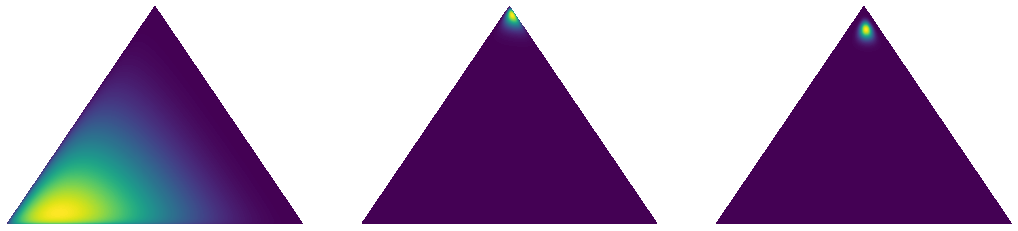

In [5]:
# Empty list for storing the 'N' most recent model alpha measurements
alpha_buf = []

# Number of alpha values to store due to limit in computational precision (?)
alpha_N = 2

for i in range(len(model_probs)):
    
    model_alpha = [1.0 + model_cs[i]*model_probs[i][0], 1.0 + model_cs[i]*model_probs[i][1], 1.0 + model_cs[i]*model_probs[i][2]]
    model_alpha_0 = sum(model_alpha)
    
    # Add model to list of most recent alphas
    if len(alpha_buf) > alpha_N:
        # Remove first element in list
        alpha_buf.pop(0)
    alpha_buf.append(model_alpha)
    
    # Compute alpha vector for 'N' most recent model measurements
    alpha = sum_alpha(alpha_buf)
    alpha_0 = sum(alpha)
    
    posterior_alpha = [prior_alpha[0] + alpha[0], prior_alpha[1] + alpha[1], prior_alpha[2] + alpha[2]]
    posterior_alpha_0 = posterior_alpha[0] + posterior_alpha[1] + posterior_alpha[2]
    
    f, axes = plt.subplots(1, 3, figsize=(18, 4))
    
    ax = axes[0]
    dist = Dirichlet(prior_alpha)
    ax = plot_dirichlet.draw_pdf_contours(ax, dist, prior_alpha)

    ax = axes[1]
    dist = Dirichlet(model_alpha)
    ax = plot_dirichlet.draw_pdf_contours(ax, dist, model_alpha)
    
    ax = axes[2]
    dist = Dirichlet(posterior_alpha)
    ax = plot_dirichlet.draw_pdf_contours(ax, dist, posterior_alpha)
    
    # Mode of model distribution
    model_mode_1 = (alpha[0] - 1.0) / (model_alpha_0 - 3.0)
    model_mode_2 = (alpha[1] - 1.0) / (model_alpha_0 - 3.0)
    model_mode_3 = (alpha[2] - 1.0) / (model_alpha_0 - 3.0)
    
    # Mode of posterior distribution
    posterior_mode_1 = (posterior_alpha[0] - 1.0) / (posterior_alpha_0 - 3.0)
    posterior_mode_2 = (posterior_alpha[1] - 1.0) / (posterior_alpha_0 - 3.0)
    posterior_mode_3 = (posterior_alpha[2] - 1.0) / (posterior_alpha_0 - 3.0)
    
    print(f"Prior ({prior_mode_1:.2f}, {prior_mode_2:.2f}, {prior_mode_3:.2f}), Model [N = {len(alpha_buf)}] ({model_mode_1:.2f}, {model_mode_2:.2f}, {model_mode_3:.2f}), Posterior ({posterior_mode_1:.2f}, {posterior_mode_2:.2f}, {posterior_mode_3:.2f})")
    plt.show()


### Conclusion

Representing object existence measurements as binomial distributions and priors as Dirichelet distributions is a natural way to represent multi-hypothesis objects and integrate information from measurements and prior knowledge.

## Example 2: Two uncertain hypotheses are resolved with contextual prior

Assumptions:
- Object observed far away, believed to be situated in a high-speed road
- Contextual classification prior defined as class-based probabilities ( p(obj) = 'car', p(obj) = 'bicycle', p(obj) = 'motorcycle')
- Contextual classification prior for road p(obj | road) = (0.91, 0.08, 0.01)

### Prior

The prior is context-dependent, meaning the classification prior is set according to the **statistical average of the road type** given the detected low-level features (i.e. some statistics of the pixel and point cloud?)

In this example, the detected object is situated in the middle of the road. Statistically we have observed that the particular low-level features likely correspond to 'car' (p = 0.65), less likely to 'motorcycle' (p = 0.34), as well as a low likelihood of 'bicycle' (p = 0.01).

Prior class distribution | mode(car, bicycle, person) = (0.65, 0.01, 0.34)


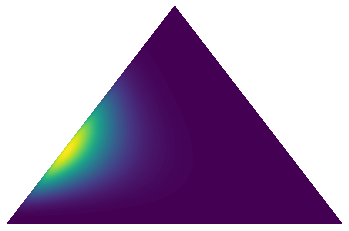

In [6]:
# Prior class distribution and precision for 'road' for the observed low-level features.
prior_prob = [0.65, 0.01, 0.34]  # [p(car), p(bicycle), p(motorcycle)]
prior_c = 10.0

prior_alpha = [1.0 + prior_c*prior_prob[0], 1.0 + prior_c*prior_prob[1], 1.0 + prior_c*prior_prob[2]]

prior_alpha_0 = prior_alpha[0] + prior_alpha[1] + prior_alpha[2]

# Mode of prior distribution
prior_mode_1 = (prior_alpha[0] - 1.0) / (prior_alpha_0 - 3.0)
prior_mode_2 = (prior_alpha[1] - 1.0) / (prior_alpha_0 - 3.0)
prior_mode_3 = (prior_alpha[2] - 1.0) / (prior_alpha_0 - 3.0)

print(f"Prior class distribution | mode(car, bicycle, person) = ({prior_mode_1:.2f}, {prior_mode_2:.2f}, {prior_mode_3:.2f})")
f, axes = plt.subplots(figsize=(6,4))
ax = axes#[0, 0]
dist = Dirichlet(prior_alpha)
ax = plot_dirichlet.draw_pdf_contours(ax, dist, prior_alpha)
plt.show()

### Measurements

The true type of the observed object is a hidden parameter we cannot observe directly.

The two deep models relying on high-level features both output a common prediction that the object is either a 'motorcycle' or 'bicycle', and very likely not a 'car'.

We assume the measurement device outputs an approximate estimates of distributions, explicitly taking into account enironmental paramters:
- Approximate distance rage (i.e. order of 10 or 100 meters?)
- Illumination (i.e. daylight or dusk)
- Approximate size of object (i.e. large truck or pedestrian?)
- etc.

In [7]:
model_1_prob = [0.01, 0.50, 0.49]
model_2_prob = [0.03, 0.47, 0.50]

model_1_c = 5
model_2_c = 7

### Bayesian inference

The true class distribution is estimated by integrating the prior and noisy measurements using Baye's theorem. This operation leverages the estimated uncertainty to integrate information from both the senses and prior knowledge in a principled manner using the laws of probability.

Biological minds are theorized to do approximate Bayesian inference as well.

Prior (0.65, 0.01, 0.34), Model 1 (0.06, 0.14, 2.37), Model 2 (0.31, 0.28, 0.41)


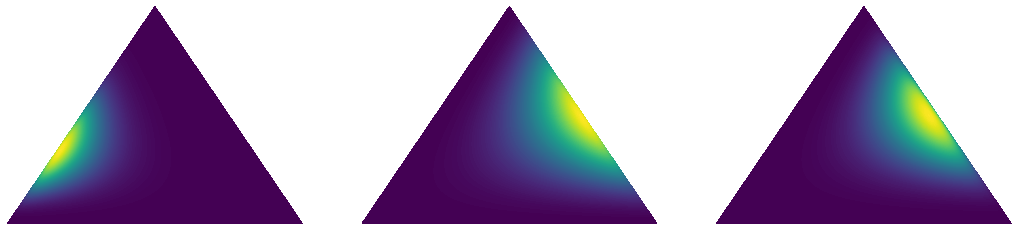

Posterior (0.31, 0.28, 0.41) ~ (p(car), p(bicycle), p(motorcycle))


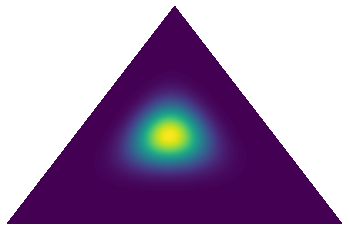

In [10]:
model_1_alpha = [1.0 + model_1_c*model_1_prob[0], 1.0 + model_1_c*model_1_prob[1], 1.0 + model_1_c*model_1_prob[2]]
model_1_alpha_0 = sum(model_1_alpha)

model_2_alpha = [1.0 + model_2_c*model_2_prob[0], 1.0 + model_2_c*model_2_prob[1], 1.0 + model_2_c*model_2_prob[2]]
model_2_alpha_0 = sum(model_2_alpha)

alpha = np.array(model_1_alpha) +  np.array(model_2_alpha)
alpha_0 = sum(alpha)

posterior_alpha = [prior_alpha[0] + alpha[0], prior_alpha[1] + alpha[1], prior_alpha[2] + alpha[2]]
posterior_alpha_0 = posterior_alpha[0] + posterior_alpha[1] + posterior_alpha[2]


f, axes = plt.subplots(1, 3, figsize=(18, 4))
    
ax = axes[0]
dist = Dirichlet(prior_alpha)
ax = plot_dirichlet.draw_pdf_contours(ax, dist, prior_alpha)

ax = axes[1]
dist = Dirichlet(model_1_alpha)
ax = plot_dirichlet.draw_pdf_contours(ax, dist, model_1_alpha)

ax = axes[2]
dist = Dirichlet(model_2_alpha)
ax = plot_dirichlet.draw_pdf_contours(ax, dist, model_2_alpha)

# Mode of model distribution
model_1_mode_1 = (model_1_alpha[0] - 1.0) / (model_1_alpha_0 - 3.0)
model_1_mode_2 = (model_1_alpha[1] - 1.0) / (model_1_alpha_0 - 3.0)
model_1_mode_3 = (model_1_alpha[2] - 1.0) / (model_1_alpha_0 - 3.0)

model_2_mode_1 = (model_2_alpha[0] - 1.0) / (model_2_alpha_0 - 3.0)
model_2_mode_2 = (model_2_alpha[1] - 1.0) / (model_2_alpha_0 - 3.0)
model_2_mode_3 = (model_2_alpha[2] - 1.0) / (model_2_alpha_0 - 3.0)

# Mode of posterior distribution
posterior_mode_1 = (posterior_alpha[0] - 1.0) / (posterior_alpha_0 - 3.0)
posterior_mode_2 = (posterior_alpha[1] - 1.0) / (posterior_alpha_0 - 3.0)
posterior_mode_3 = (posterior_alpha[2] - 1.0) / (posterior_alpha_0 - 3.0)

print(f"Prior ({prior_mode_1:.2f}, {prior_mode_2:.2f}, {prior_mode_3:.2f}), Model 1 ({model_mode_1:.2f}, {model_mode_2:.2f}, {model_mode_3:.2f}), Model 2 ({posterior_mode_1:.2f}, {posterior_mode_2:.2f}, {posterior_mode_3:.2f})")
plt.show()


f, axes = plt.subplots(figsize=(6, 4))
    
ax = axes
dist = Dirichlet(posterior_alpha)
ax = plot_dirichlet.draw_pdf_contours(ax, dist, posterior_alpha)

print(f"Posterior ({posterior_mode_1:.2f}, {posterior_mode_2:.2f}, {posterior_mode_3:.2f}) ~ (p(car), p(bicycle), p(motorcycle))")
plt.show()


### Conclusion

The Bayesian treatment naturally manage the integration of prior knowledge and uncertain measurements by resolving the ambiguity between 'bicycle' and 'motorcycle' by invoking the strong prior that "motorcycles are more likely to be on a high-speed road than bicycles".

Still, as the model output uncertainty is high, the prior probability of the detected object actually being a 'car' is still taken into consideration.